

EVT from [here](https://www.youtube.com/watch?v=eUWlzAQfgFw&t=472s) and [here](https://www.econstor.eu/bitstream/10419/195412/1/894604031.pdf).

In [ ]:
install.packages('evir')
library('evir')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



First of all, plotting and getting summary statistics.

An exponential q-plot will be the first test to check at the tails. Data from the normal distribution will be convex.


In [ ]:
install.packages('quantmod')
require('quantmod')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Loading required package: quantmod

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
getSymbols("DJIA", from="1990-01-02", to="2021-01-06", src="FRED", auto.assign = getOption('loadSymbols.auto.assign',TRUE))
stock.rtn=diff(log(`DJIA`))
losses <- as.vector(-stock.rtn)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "DJIA"

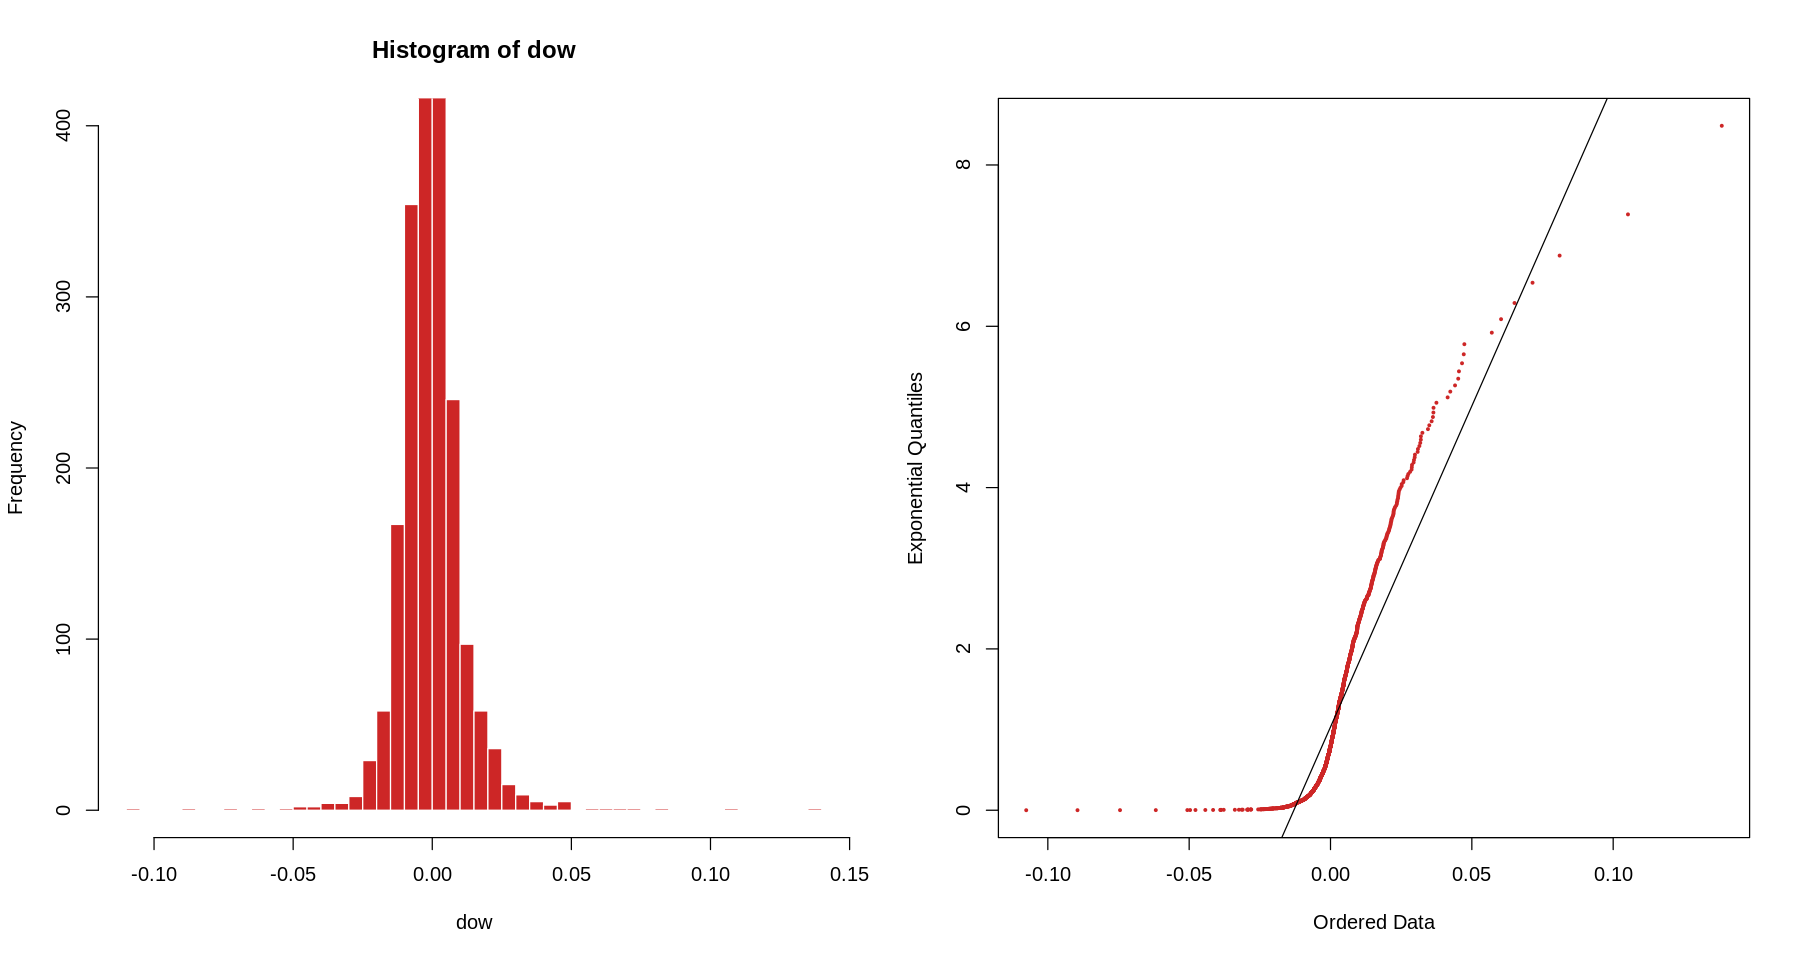

In [ ]:
dow <- na.omit(losses)

options(repr.plot.width=15, repr.plot.height=8)
par(mfrow=c(1,2))

hist(dow, border=F, col='firebrick3', breaks=60, ylim=c(0,400))
qplot(dow, xi=0, pch=19, col='firebrick3', cex=.3)

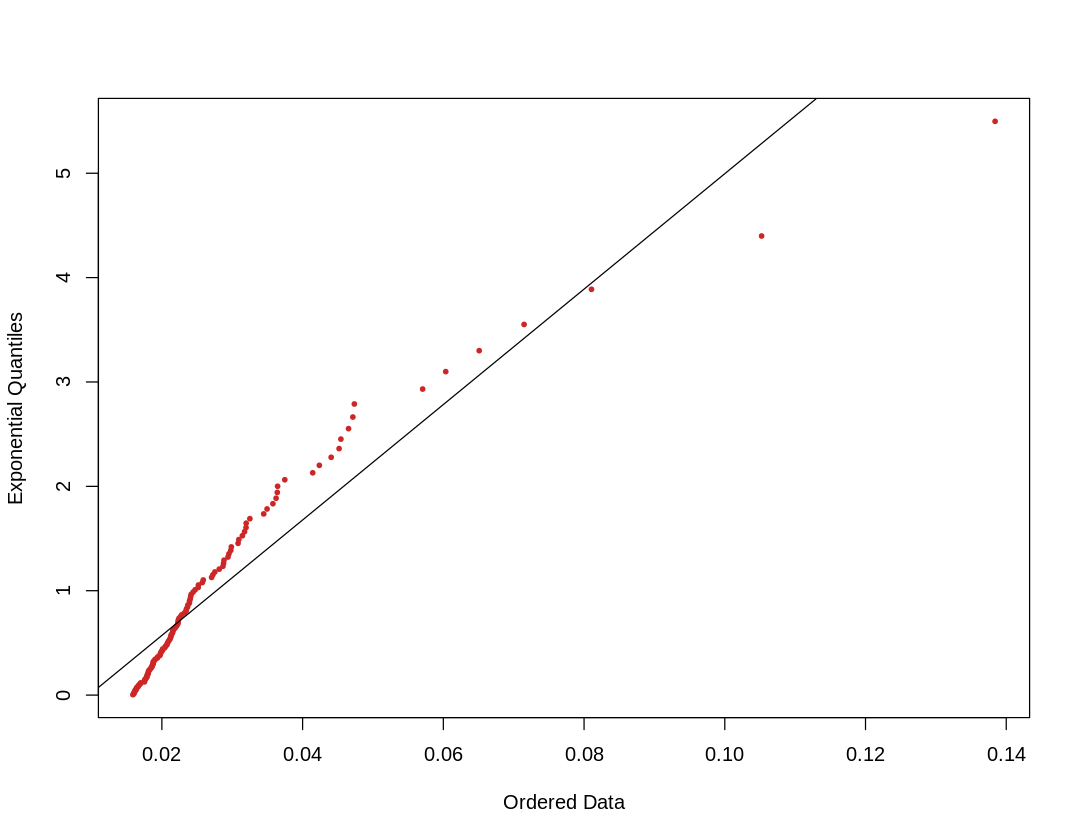

In [ ]:
# What if there are mixed distributions... Let's explore just the top 5-th quantile:
options(repr.plot.width=9, repr.plot.height=7)
dow.top <- dow[dow>=quantile(dow, 0.95)]
qplot(dow.top, xi=0, pch=19, col='firebrick3', cex=.5)

Once we get a strong signal of heavy tails (concavity in the exponential Q-Q plot), we look for fat tails.

The Zipf plot will give us information on the survival function.

A linear plot will suggest that the data is distributed like a Pareto, i.e. fat tails, not just heavy tails.

It detects power-law decay at the tail. It is a necessary condition, but not sufficient. If there is no linearity, we rule out fat tails, but the lognorm distribution can look very similar to the linear plot of a Pareto.

The Zipf plot is a log-log plot of the empirical survival function of our data.

It comes from the observation that in a Pareto

$\bar F(x) = \left(\frac{x}{x_0} \right)^{-\alpha},\quad 0<x_0\leq x \implies \log(\bar F(x))= \alpha \log(x_0) - \alpha \log(x).$

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1323 x values <= 0 omitted from logarithmic plot”


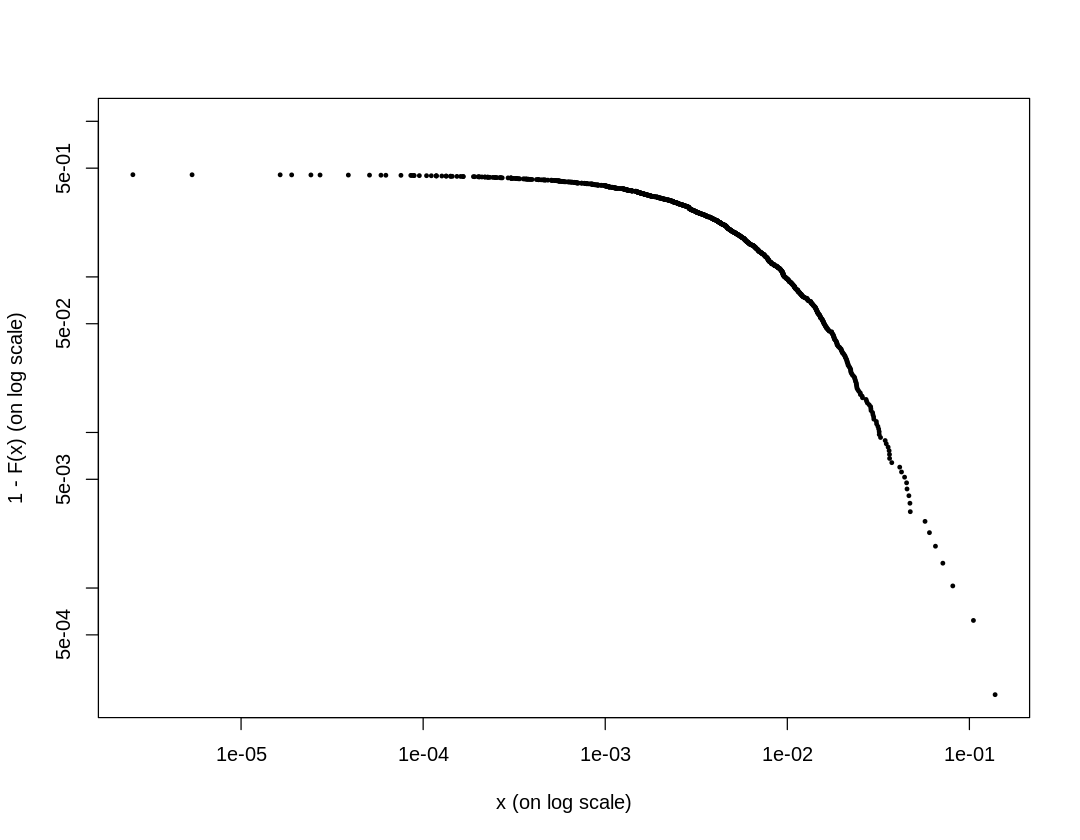

In [ ]:
# Here is the Zipf plot of the log of the data (x) and the empirical survival (y)

emplot(dow, 'xy', pch=19, cex=.4)

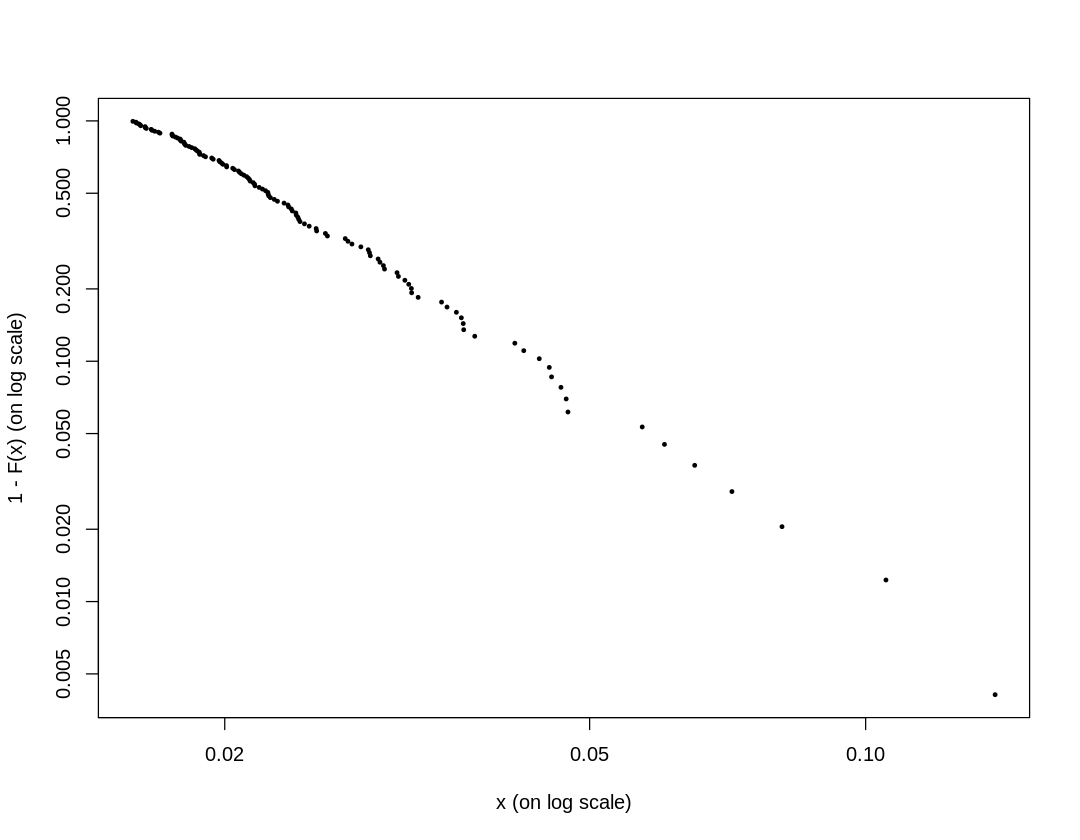

In [ ]:
options(repr.plot.width=9, repr.plot.height=7)
emplot(dow.top,'xy',pch=19, cex=.4)

But the Zipf plot is not enough.

The MEF (Mean Excess Function) of a rv $X$ with a cdf $F$ is

$$e(v) = E[X-v \mid X>v]=\frac{\int_v^\infty (t-v) dF(t)}{\int_v^\infty dF(t)}$$

So it is the expected value of the all the observations above a threshold $v$ rescaled by the threshold.

Note that there has to be a finite mean (expectation), which only happens when the alpha value of the Pareto is above 1.

The Meplot will yield a plot consistent with the Wijk's law (the mean excess function of a Pareto grows linearly with the threshold). Another signal of fat tails.



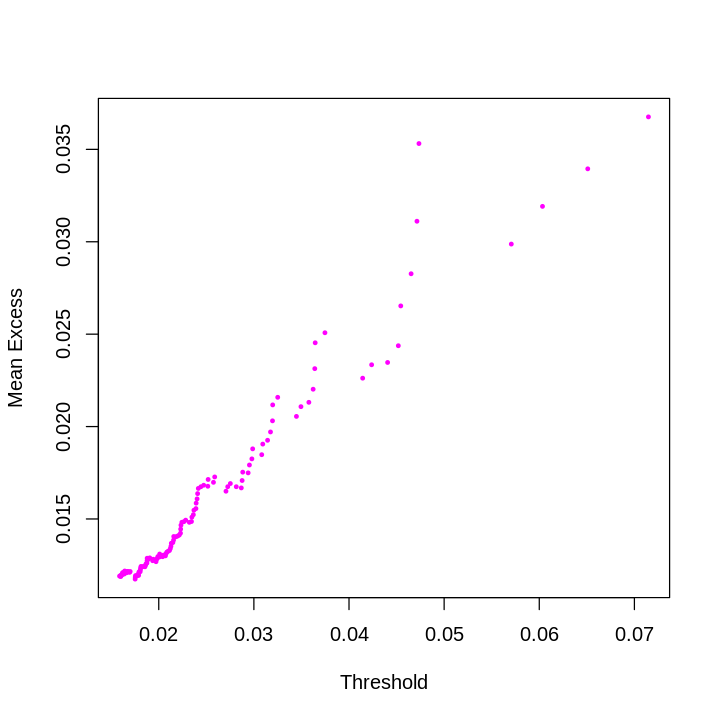

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
meplot(dow.top, pch=19, col='magenta', cex=.4)

Next, the concentration profile (CP):


In [ ]:
install.packages('ineq')
library('ineq')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



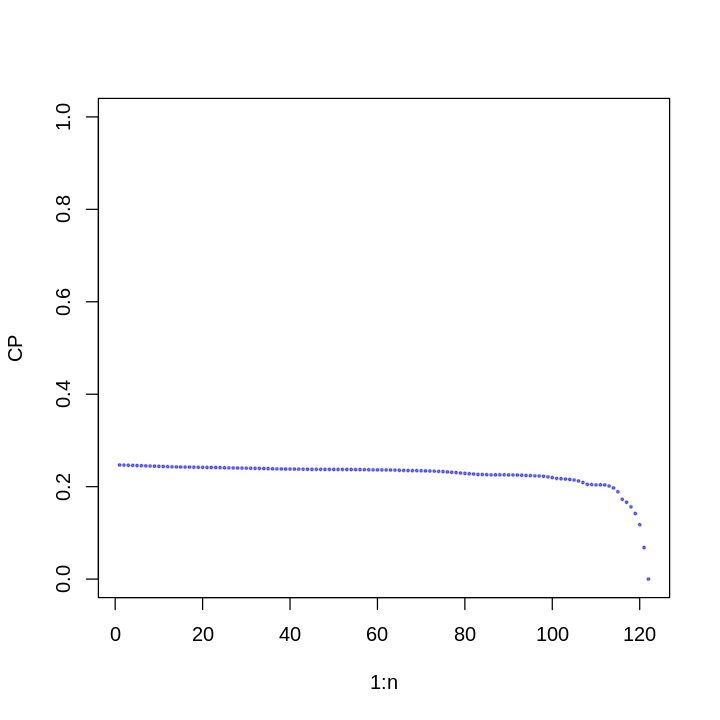

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
sort_danish = sort(dow.top)
n=length(dow.top)
CP=c()
for (i in 1:n) CP[i]=ineq(sort_danish[i:n], type='Gini')

plot(1:n,CP,ylim=c(0,1),pch=19, cex=.3, col=rgb(0, 0, 100, max = 100, alpha = 50))

From [here](https://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm):

$$G=\frac{\sum_{i=1}^n\sum_{j=1}^n\vert x_i - x_j \vert}{2n^2 \bar x}$$

or If the x values are first placed in ascending order, such that each x has rank i, the some of the comparisons above can be avoided and computation is quicker:

$$G=\frac{2}{n^2 \bar x}i\sum_{i=1}^n x_i - \bar x $$


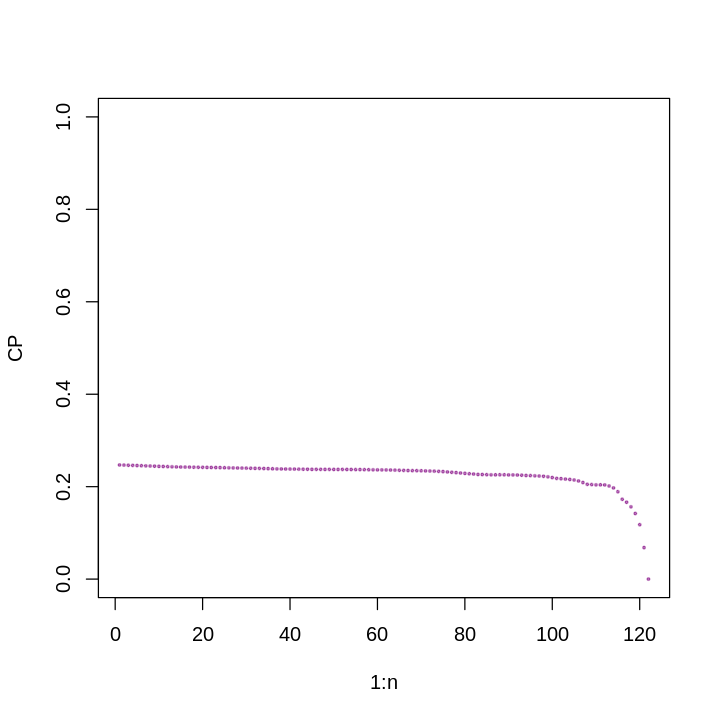

In [ ]:
# Here is the "manual" calculation. It takes several minutes to compute!
# To un-comment or comment the cell, select all lines and press Ctrl /

v = sort(dow.top, decreasing = FALSE) # Places in order the actual entries in the vector 'danish' from smaller to larger.

n = length(dow.top) # 2167 claims

CP <- rep(0,n)     # Empty vector to collect Gini index for every progressively more extreme segment of v.
for (i in 1:n){    # We will chop off the vector v in 2167 spots from left to right, keeping only the values to the r each time.
      mat <- matrix(0, n-i+1 , n-i+1) # Each string to be Gini measured and the results stored in a matrix of size (n - i + 1)^2.
        for (j in 1:(n-i+1)){         # We will fill in the matrix one row at a time, each row indexed by j.
         mat[j,] <- abs(v[i+j-1] - v[i:n]) # This takes the diffence between each element to the right of the i-th entry, starting at i
                                           # ... and the entire string of elements to the right of the i-th position in v. Abs. values.
           }
       CP[i] <- sum(mat) / (2 * (n-i+1)^2 * mean(v[i:n])) # This calculates the Gini index for each submatrix.
}

plot(1:n,CP,ylim=c(0,1),pch=19, cex=.3, col=rgb(50, 0, 50, max = 100, alpha = 50))

In [ ]:
# # For an "under-the-hood" view of what this does, here is the same calculation on a sort vector, printing intermediate steps:

# set.seed(0)

# v = round(runif(3,2,35))
# v
# n = length(v)

# CP <- rep(0,n)
# for (i in 1:n){
#   mat <- matrix(0, n-i+1 , n-i+1)
#   for (j in 1:(n-i+1)){
#     mat[j,] <- abs(v[i+j-1] - v[i:n])
#     print(mat)
#   }
#   CP[i] <- sum(mat) / (2 * (n-i+1)^2 * mean(v[i:n]))
#   print(CP)
# }

This constant concentration profile (except at the margin) is typical of Pareto distributions.

To analyze the moments we can use the function MS.

The ratio of maximum-to-sum for a particular moment $k$ will converge a.s. to $0$ if the moement is finite:

For an iid sequence $X_1,\dots,X_n$

$$S_n(k)=\sum_1^n \vert X_i \vert^k$$

$$M_n(k) =\max_{i\in\{1,\dots, n\}}(\vert X_i \vert^k)$$

will result in

$$R_n(k)=\frac{M_n(k)}{S_n(k)}$$

by the LLN, $R_n(k) \to 0$ if $\mathbb E(X^k)<\infty.$

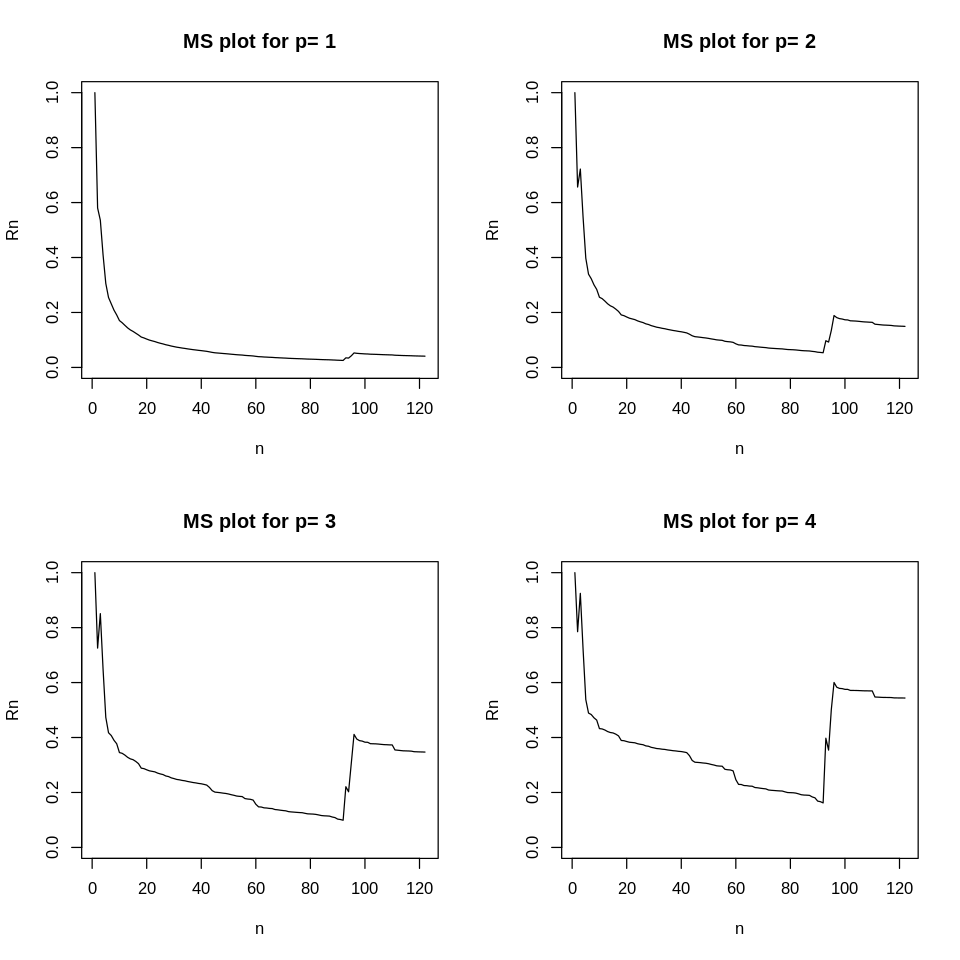

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
MSplot <- function(data, p=4){
  par(mfrow=c(2,2))
  x=abs(data)
  for(i in 1:p){
    y=x^i
    S=cumsum(y)
    M=cummax(y)
    R=M/S
    plot(1:length(x),R,type='l',ylim=c(0,1), xlab='n',ylab='Rn',main=paste('MS plot for p=',i))
  }
  par(mfrow=c(1,1))
}
MSplot(dow.top)

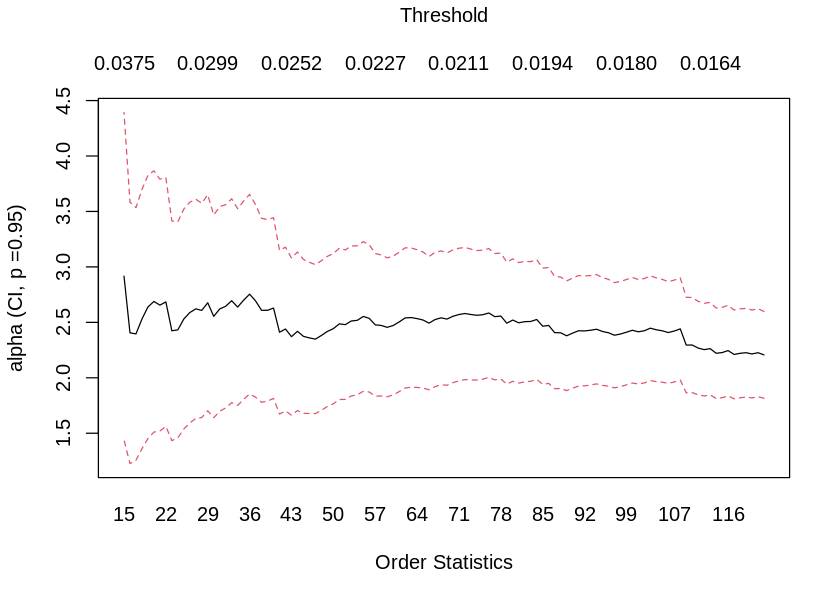

In [ ]:
# Trying the same with a Hill plot:
options(repr.plot.width=7, repr.plot.height=5)
hill(dow.top)

Let us fit a GPD above such a threshold. If the fit is reliable, the tail parameter should be stable under higher thresholds.

Trying to fit a generalized Pareto:

In [ ]:
fit = gpd(dow.top,0.025) # 0.024 is where the Hill plot seems to start to converge.
tail(fit)

0.0371125023,-3.367683e-04
-0.0003367683,7.992244e-06


We get a xi = 0.28 with a se of 0.19. The beta of 0.0119.

! $\beta$ beta is the scale parameter!

! $\mu$ is the location parameter.

This is found [here](https://cran.r-project.org/web/packages/evir/evir.pdf).

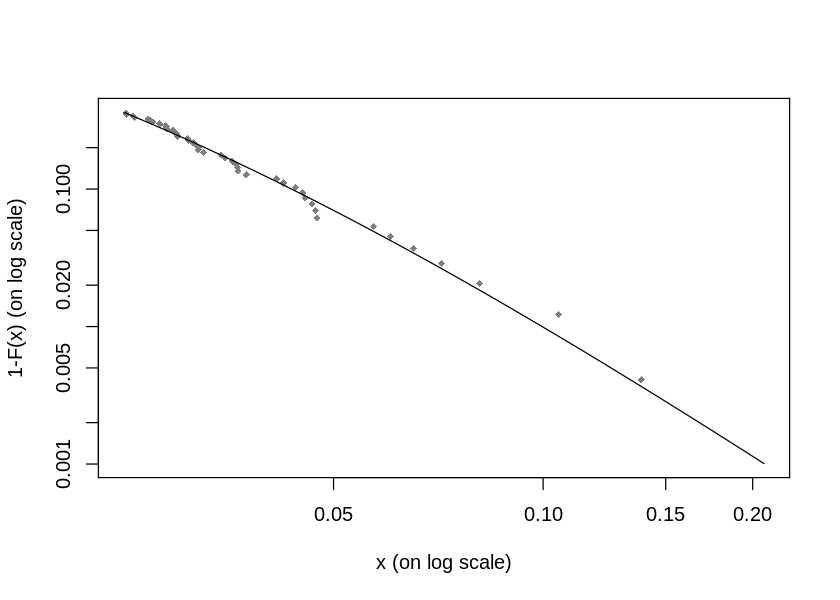

In [ ]:
options(repr.plot.width=7, repr.plot.height=5)

tailplot(fit, pch=18, cex=.8, col='gray50')

Note that plot(fit) does not work on Jupyter because it wants to launch an interactive menu, but it does when run in RStudio.


Would a higher threshold change the value of xi?

In [ ]:
gpd(dow.top,0.1)$par.ests[1]
gpd(dow.top,0.1)$par.ses[1]

Warning message in gpd(dow.top, 0.1):
“optimization may not have succeeded”


xi 
-1.608925

Warning message in gpd(dow.top, 0.1):
“optimization may not have succeeded”


xi 
1.99997e-06

In [ ]:
riskmeasures(fit,0.99)

p,quantile,sfall
0.99,0.09966028,0.1462911


The empirical counterparts are

In [ ]:
quantile(dow.top,0.99) #99% Var
mean(dow.top[dow.top>=quantile(dow.top,0.99)]) #99% ES

99% 
0.100155

[1] 0.1218251

In [ ]:
riskmeasures(fit,0.999)

p,quantile,sfall
0.999,0.2081543,0.2982452


Lower CI   Estimate   Upper CI 
0.09001118 0.14629108 0.20762720

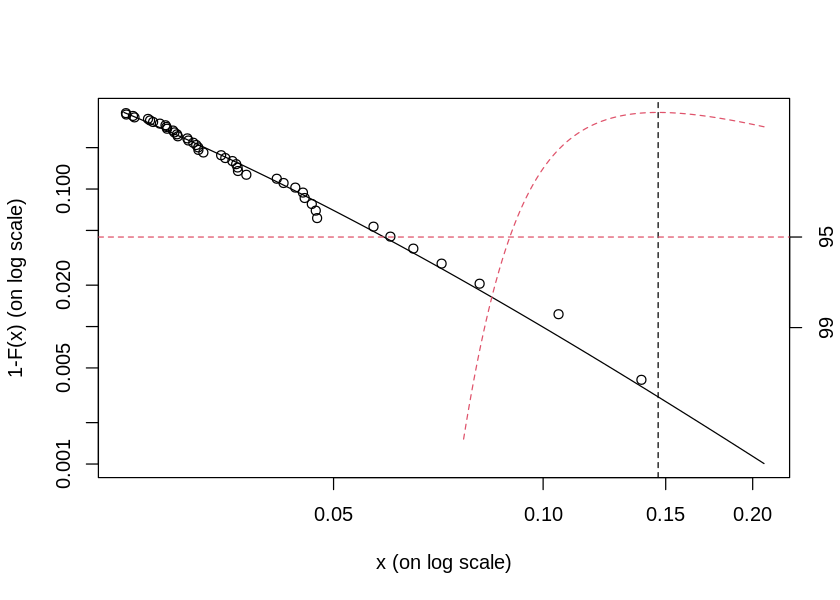

In [ ]:
options(repr.plot.width=7, repr.plot.height=5)

gpd.sfall(tailplot(fit), 0.99, ci.p = 0.95)